# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filename2 = 'newDB'#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [3]:
if False:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)
    data['phi0'] = data['phi0'].astype('int32')
    data['centrality'] = data['centrality'].astype('int32')
    data['zvertex'] = data['zvertex'].astype('float16')
    data['pt'] = data['pt'].astype('float16')
    data['e/p'] = data['e/p'].astype('float16')
    data['n0'] = data['n0'].astype('int32')
    data['disp'] = data['disp'].astype('float16')
    data['chi2'] = data['chi2'].astype('float16')
    data['npe0'] = data['npe0'].astype('int32')
    data['prob'] = data['prob'].astype('float16')
    data.head()
    
    data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
    data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
    data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
    data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
    data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
    data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
    #data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
    #data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
    data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
    data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
    data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
    data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
    data.head()

In [4]:
data = pd.read_csv(filepath+f'{filename2}.csv')
#data2.loc[data2['phi0'] > -99, 'phi0'] = 1
#data2 = data2[:100000]

In [5]:
print(data.size, data.shape)

261258888 (10885787, 24)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


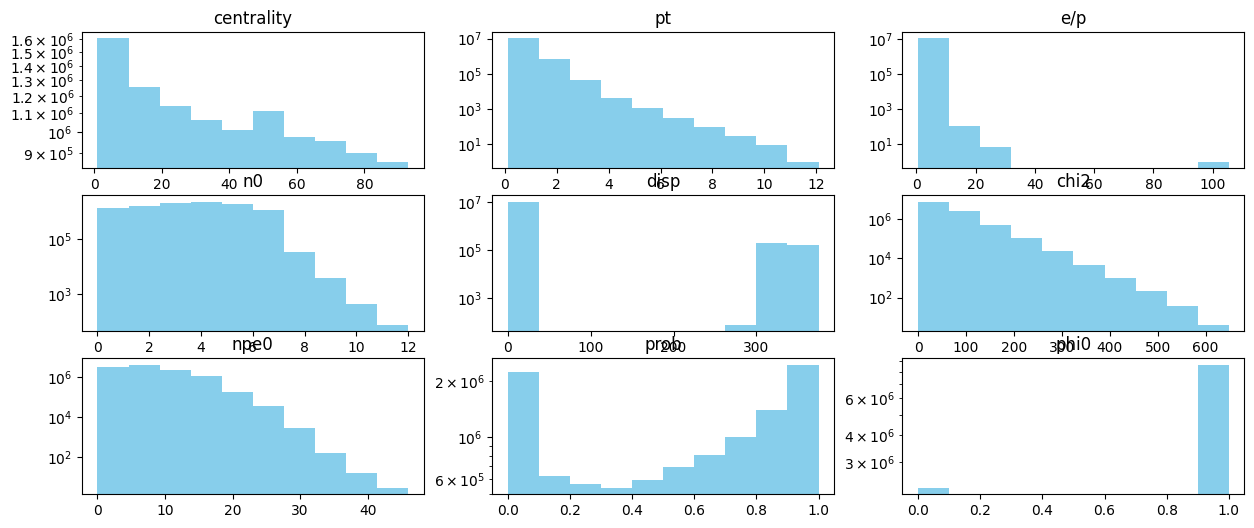

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [10]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

3628595 7257192


In [11]:
X_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob,disp2,n0*disp,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
7257192,75,0.3777,0.8013,3,3.875,35.660,9,0.618700,15.015625,0.205128,...,9.970879e-07,0.619652,1.619324,9.904943e-07,0.615374,3.0,0.000002,2.647705,0.142646,0.000178
7257193,42,0.5780,0.8276,3,6.395,101.900,7,0.000994,40.890030,0.135235,...,7.589982e-07,0.001994,1.000492,5.807428e-04,0.761003,3.0,0.000764,1.729730,0.334229,0.000567
7257194,8,0.4836,0.9530,3,5.984,24.220,4,0.159700,35.812744,0.143177,...,3.743777e-03,0.160668,1.090867,1.630626e-02,0.696163,3.0,0.023447,2.067643,0.233910,0.015625
7257195,17,0.5920,0.8220,1,6.457,135.200,1,0.520000,41.693253,-0.134102,...,2.466207e-04,-0.521020,1.443390,3.648347e-04,-0.769933,-1.0,0.000474,1.689769,0.350224,0.003460
7257196,36,0.5107,0.9277,2,4.312,79.440,4,0.944000,18.597656,0.000000,...,1.539988e-02,0.000000,4.219659,1.166048e-02,0.000000,0.0,0.016316,1.957935,0.260858,0.000772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10885782,70,0.3953,0.9326,2,5.170,83.100,3,0.925000,26.748291,0.000000,...,1.626483e-02,0.000000,3.646496,1.105715e-02,0.000000,0.0,0.017587,2.529957,0.156233,0.000204
10885783,11,0.3435,1.3940,2,3.460,10.350,4,0.002916,11.978088,0.000000,...,1.027446e-03,0.000000,1.001456,2.064850e-01,0.000000,0.0,0.352307,2.911158,0.117996,0.008264
10885784,67,0.8853,0.8496,3,1.307,4.402,3,0.170500,1.707310,0.433531,...,4.196952e-04,0.171532,1.097988,2.315589e-03,0.941411,3.0,0.002461,1.129619,0.783674,0.000223
10885785,67,1.5030,0.9707,3,2.773,47.900,6,0.936500,7.691956,0.265010,...,2.728988e-02,0.937523,3.968799,3.572336e-02,1.226348,3.0,0.029140,0.665367,2.258798,0.000223


In [12]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [13]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.21      1.00      0.34    753582
           1       0.00      0.00      0.00   2875013

    accuracy                           0.21   3628595
   macro avg       0.10      0.50      0.17   3628595
weighted avg       0.04      0.21      0.07   3628595

confusion matrix
[[ 753582       0]
 [2875013       0]]


In [14]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[3,10],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[8,10,12,20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.30245756277567487
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}
0.3156792101835498
time of execution (sec) 1668.8483278751373


# Cross Validation

In [15]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.23      1.00      0.37    753582
           1       1.00      0.12      0.21   2875013

    accuracy                           0.30   3628595
   macro avg       0.61      0.56      0.29   3628595
weighted avg       0.84      0.30      0.25   3628595



In [16]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.015305684877522359
roc auc: 0.9583853238816267
f1 score: 0.921781636733052


Text(0.5, 1.0, 'ROC AUC Curve')

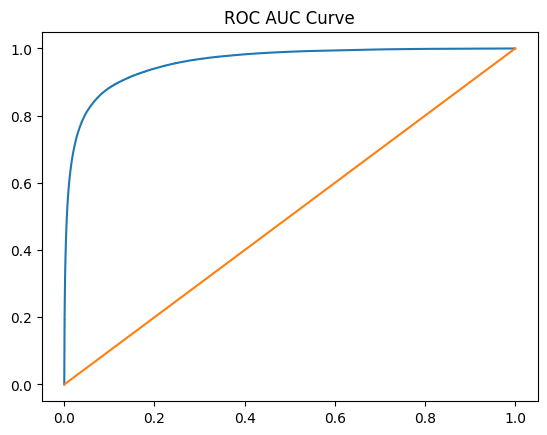

In [17]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

In [18]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.5108648767426065


In [92]:
i = 200000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.612 0.019
0.024720436431624623 0.011628462463275396 0.6120441890175801


In [20]:
print(sum(predicted),len(predicted))

344528 3628595


In [21]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.9531708367176029


In [95]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1+hadron_weight
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1+hadron_weight
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [96]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

70884 49299712.0 0.52 0.012 0.622 0.01 0.016 0.019


In [97]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

1.548 1.195 0.772 1935


In [25]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[1 0 0 0 0 0 0 0 0 0]


In [26]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[1 0 0 0 0 0 0 0 0 0]


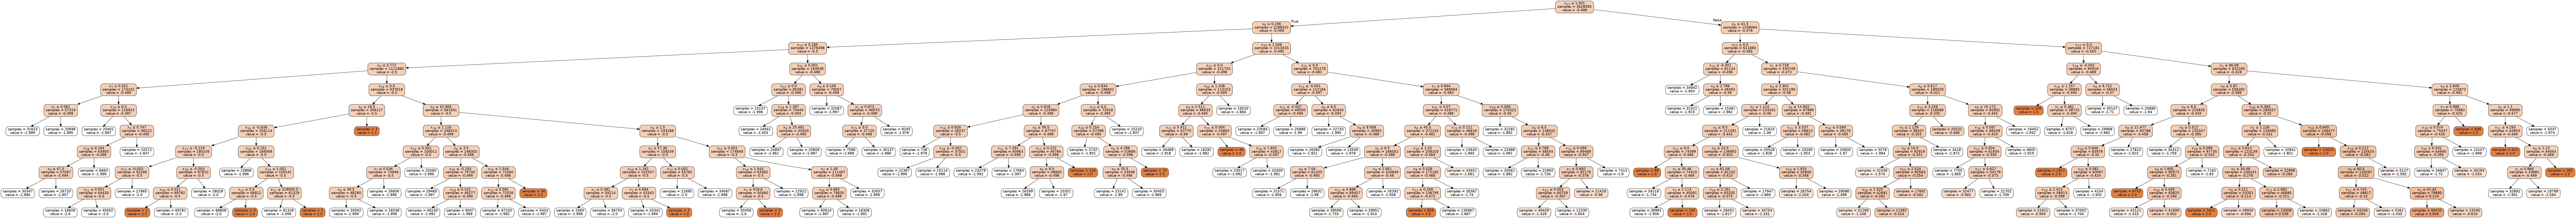

In [27]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [28]:
clf2.predict(kek_data[0:100])

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [29]:

clf2.predict_proba(kek_data[0:100])


array([[0.04682916, 0.95317084],
       [0.99137281, 0.00862719],
       [0.84163091, 0.15836909],
       [0.72569043, 0.27430957],
       [0.98800969, 0.01199031],
       [0.68916625, 0.31083375],
       [0.99143168, 0.00856832],
       [0.80105764, 0.19894236],
       [0.74490646, 0.25509354],
       [0.9865836 , 0.0134164 ],
       [0.38797342, 0.61202658],
       [0.98130314, 0.01869686],
       [0.74061839, 0.25938161],
       [0.94297667, 0.05702333],
       [0.98323221, 0.01676779],
       [0.99131974, 0.00868026],
       [0.5297298 , 0.4702702 ],
       [0.31071458, 0.68928542],
       [0.13375258, 0.86624742],
       [0.25749673, 0.74250327],
       [0.99137246, 0.00862754],
       [0.98809101, 0.01190899],
       [0.97373127, 0.02626873],
       [0.06413708, 0.93586292],
       [0.98196424, 0.01803576],
       [0.91921622, 0.08078378],
       [0.88726275, 0.11273725],
       [0.9815692 , 0.0184308 ],
       [0.82766616, 0.17233384],
       [0.60953253, 0.39046747],
       [0.

In [30]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}


In [31]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.9865836 , 0.0134164 ],
       [0.38797342, 0.61202658],
       [0.98130314, 0.01869686],
       [0.74061839, 0.25938161],
       [0.94297667, 0.05702333],
       [0.98323221, 0.01676779],
       [0.99131974, 0.00868026],
       [0.5297298 , 0.4702702 ],
       [0.31071458, 0.68928542],
       [0.13375258, 0.86624742],
       [0.25749673, 0.74250327]])

In [32]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-2.59473557 -0.23985081 -2.59099764 -1.2328782  -2.0188138  -2.58641139
 -2.69290523 -0.64073833  0.09233835  0.51544447]
[-5.2946622  -3.90390716 -5.90257477 -3.33053542 -2.00617495 -6.24966946
 -7.31799239 -2.5568566  -1.41462703 -1.94987928 -3.90390716]
[0.069478   0.44032312 0.06972005 0.22567807 0.1172417  0.0700181
 0.0633933  0.34507966 0.5230682  0.62608192]


In [33]:
best_gbc = clf2.best_estimator_

In [66]:
n_estim = best_gbc.n_estimators

In [34]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-4.29777023  0.45583887 -3.96052604 -1.04918515 -2.805581   -4.07138549
 -4.7379861  -0.11905964  0.79678071  1.86817893]
[0.0134164  0.61202658 0.01869686 0.25938161 0.05702333 0.01676779
 0.00868026 0.4702702  0.68928542 0.86624742]
0.2


In [35]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [36]:
print(log_odds_predictions)

[[-1.9905717724362826, -0.9927627112793548, -1.9846369379195272, -1.5836149057498863, -1.616909555973793, -1.9863397496304083, -1.9995969700769662, 2.0, 0.9058894296494777, 0.9058894296494777], [-1.6536282311651296, 0.387076179839798, -1.6541609984281622, -0.5896329345890826, -1.3342729314692485, -1.6517930104892093, -1.669213080871223, -0.7602324426914114, -1.3990285042479649, -0.5672154126789113], [-1.4716709921190385, 0.8791013505108508, -1.4778880876355664, -1.4194346974161614, -1.4220997478288167, -1.380057911066496, -1.4783886604722583, -1.0567952212645524, -0.3914661382449191, -0.08901117952710212], [-1.3492199658918795, 0.34462415033035665, -1.1943068025078192, -0.9919345771184035, -0.8178486241423478, -1.3370685778137648, -1.3567273984915087, -0.3850249319514992, 0.3387274791317556, 1.5952596232910972], [-1.2440430389175974, -0.6699317450404555, -1.2299191085273173, -0.6411088101837676, -0.9596063496673919, -1.216558831187532, -1.2719558249800147, -0.7995716094548272, 0.629615

In [37]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 -2.594735570564786
[-4.29777023  0.45583887 -3.96052604 -1.04918515 -2.805581   -4.07138549
 -4.7379861  -0.11905964  0.79678071  1.86817893]


In [67]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[-1.9905717724362826, -1.6536282311651296, -1.4716709921190385, -1.3492199658918795, -1.2440430389175974, -1.2045303655998998, -1.0036718467718935, -1.083011814281246, -1.0908644032276282, -0.8824654224133304, -1.0481413478611323, -0.9669714737885119, -0.9698723107713516, -0.9504174485729857, -0.6902591192883458, -0.6507752016293799, -0.8810794918853692, -0.9134766529488496, -0.6487604888715476, -0.7954197584820889], [-0.9927627112793548, 0.387076179839798, 0.8791013505108508, 0.34462415033035665, -0.6699317450404555, -0.6500219297713412, -0.23629001729607665, -1.0455097867710088, 0.005163021004792442, 0.7792974503477869, -0.8963244257777099, 0.004490276869743156, 0.17783863106463804, 1.4914414941609828, 0.4182901153327471, 0.4936194993125286, 0.38474618736397054, 1.1472832277392067, 0.10700551223597177, 0.15005785049467765], [-1.9846369379195272, -1.6541609984281622, -1.4778880876355664, -1.1943068025078192, -1.2299191085273173, -1.2024051645936833, -1.0267970060348464, -1.11616

In [68]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " && "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " y = "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [69]:
iestim = 1
sub_tree = clf2.best_estimator_[iestim, 0]
rules = get_rules(sub_tree, list(kek_data.columns), None)
print(f"double mytree{list(kek_data.columns)}")
print('{')
#for r in rules:
#    print("    ",r)
print ('return y;')
print('};')

double mytree['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'disp2', 'n0*disp', 'n0*disp2', 'chi2/npe0', 'e/p*prob', 'n0*prob', 'prob-1', 'e/p*pt', 'n0*pt', 'n0-2', 'e/p-0.8', 'pt-1', 'pt2', 'centrality-2']
{
return y;
};


In [70]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [71]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return y')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[13] <= 1.00101) and (x[9] > 0.19594) and (x[14] > 1.04621) and (x[15] > 0.0004) and (x[1] <= 0.84435) and (x[15] <= 0.07043) and (x[0] > 40.5) and (x[10] <= 1.4201) and (x[9] <= 0.52804) and (x[11] > 0.26883) :  return -1.8867162714605064  # | based on 135,967 samples
        if (x[13] <= 1.00101) and (x[9] <= 0.19594) and (x[13] <= 0.28506) and (x[4] > 3.772) and (x[18] <= 0.00028) and (x[6] <= 18.5) and (x[16] > -0.63845) and (x[20] > 0.15097) and (x[14] > 1.05185) and (x[11] <= 319000.0) :  return -1.9994151476254776  # | based on 81,328 samples
        if (x[13] <= 1.00101) and (x[9] <= 0.19594) and (x[13] <= 0.28506) and (x[4] > 3.772) and (x[18] <= 0.00028) and (x[6] <= 18.5) and (x[16] <= -0.63845) and (x[13] > -0.21909) and (x[18] <= -0.00293) and (x[20] > 0.02075) :  return -1.9999623001773772  # | based on 69,781 samples
        if (x[13] <= 1.00101) and (x[9] <= 0.19594) and (x[13] <= 0.28506) and (x[4] > 3.772) an

In [77]:
def mytree(x,y):
    return 0

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (1538746709.py, line 1)

In [74]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [78]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [75]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.88246542  0.77929745 -0.98312515  0.03413913 -0.89557104 -0.98717696
 -1.08317717  0.02429307  0.10185037  0.02429307]
[-0.8824654224133304, 0.7792974503477867, -0.9831251507442799, 0.034139131726789125, -0.8955710424430311, -0.9871769645172429, -1.0831771682420397, 0.024293072286116782, 0.10185036790960958, 0.024293072286116782]


In [76]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.9865836  0.0134164 ]
 [0.38797342 0.61202658]
 [0.98130314 0.01869686]
 [0.74061839 0.25938161]
 [0.94297667 0.05702333]
 [0.98323221 0.01676779]
 [0.99131974 0.00868026]
 [0.5297298  0.4702702 ]
 [0.31071458 0.68928542]
 [0.13375258 0.86624742]]
[0.013416399964386977, 0.6120265765129771, 0.018696856020828885, 0.2593816054352918, 0.0570233329633929, 0.016767790778281538, 0.008680256042627512, 0.4702702013295225, 0.6892854221291244, 0.8662474239249335]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [98]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1+hadron_weight
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1+hadron_weight
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    if counter<20: 
        print(proba_loc[counter],mygradboost(kek_data[0+counter:1+counter].values.tolist()[0]),mybdt(kek_data[0+counter:1+counter].values.tolist()[0],thresholds[i]),phi0)
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

[0.04682916 0.95317084] 0.9531708367176029 1 1.0
[0.99137281 0.00862719] 0.008627186435049526 0 0.0
[0.84163091 0.15836909] 0.1583690949410099 1 1.0
[0.72569043 0.27430957] 0.27430956729970013 1 1.0
[0.98800969 0.01199031] 0.011990310069667554 0 1.0
[0.68916625 0.31083375] 0.3108337517885535 1 1.0
[0.99143168 0.00856832] 0.00856832259979767 0 0.0
[0.80105764 0.19894236] 0.19894236299000376 1 1.0
[0.74490646 0.25509354] 0.2550935353174467 1 1.0
[0.9865836 0.0134164] 0.013416399964386977 0 1.0
[0.38797342 0.61202658] 0.6120265765129771 1 1.0
[0.74061839 0.25938161] 0.2593816054352918 1 1.0
[0.94297667 0.05702333] 0.0570233329633929 1 1.0
[0.98323221 0.01676779] 0.016767790778281538 0 1.0
[0.99131974 0.00868026] 0.008680256042627512 0 1.0
[0.5297298 0.4702702] 0.4702702013295225 1 1.0
[0.31071458 0.68928542] 0.6892854221291244 1 1.0
[0.13375258 0.86624742] 0.8662474239249335 1 1.0
[0.25749673 0.74250327] 0.7425032669197162 1 1.0
1.548 1.195 0.772 1935


In [47]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define parameters for GridSearch
parameters = {
    "loss": ["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [2, 5],
    "max_depth": [3, 8],
    "max_features": ["log2", "sqrt"],
    "criterion": ['friedman_mse'],
    "n_estimators": [1]
}

classif = GradientBoostingClassifier()
classif.set_params(init='zero')
# Create a GridSearchCV object
clf3 = GridSearchCV(classif, parameters, cv=2, n_jobs=1)

# Sample data
X_train = np.array([[0, 0], [1, 1], [0, 1], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [1, 1]])
y_train = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

# Fit the model
clf3.fit(X_train, y_train)

# Get the best estimator
best_estimator = clf3.best_estimator_
print(best_estimator.get_params())

# Get the initial prediction (base learner's output)
initial_prediction = 0#best_estimator.init_.predict(X_train)
# Convert initial predictions to probabilities
initial_probabilities = 1 / (1 + np.exp(-initial_prediction))
# Convert initial probabilities to log odds
initial_log_odds = np.log(initial_probabilities / (1 - initial_probabilities))

# Initialize an array for the decision function
manual_decision_function = initial_log_odds.copy()

# Iterate over trees in the best estimator
for tree in best_estimator.estimators_:
    # Get leaf indices for training data
    leaf_indices = tree[0].apply(X_train)
    
    # Get average values at each leaf (contributions)
    leaf_values = tree[0].tree_.value[:, 0, 0]  # Average target value for each leaf
    
    # Calculate contribution from this tree
    contribution = leaf_values[leaf_indices] * best_estimator.learning_rate
    
    # Accumulate contributions
    manual_decision_function += contribution

# Output the results
print("My Decision Function (Log Odds):", manual_decision_function)
print("Decision Function Output:", clf3.decision_function(X_train))
print("Decision Function other Output:", clf3.best_estimator_.decision_function(X_train))
print(X_train.shape[0])

# Calculate the differences
difference = np.abs(manual_decision_function - clf3.decision_function(X_train))
print("Differences:", difference)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': 'zero', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
My Decision Function (Log Odds): [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function other Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714

/home/yoren/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
